# <img style="float: left; padding-right: 10px; width: 45px"> GEC AI HUB: Introduction to Data Science and Machine Learning



## Lab 2:  Decision Trees and Random Forests -- Part 1

**GEC AI Hub**<br>
**Summer 2019**<br>
**Instructors:** Pavlos Protopapas<br>
**Lab Instructors:** Patrick Ohiomoba and Esteban Reyes<br>

---

In [37]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals
In this lab, we'll explore tree based models and ensembles in order to solve problems of classification and regression.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - Decision Trees and Random Forest
 
- Be able to understand when Decision Trees and Random Forests overfit 

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn.apionly as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.datasets import make_blobs

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/home/igodo/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


### Impurity Indices

#### Entropy

The entropy is defined as
$$I_H(t) = - \sum_{i =1}^{C} p(i \mid t) \;log_2 \,p(i \mid t)$$

for all non-empty classes ($p(i \mid t) \neq 0$), where $p(i \mid t)$ is the proportion (or frequency or probability) of the samples that belong to class $i$ for a particular node $t$; $C$ is the number of unique class labels.

The entropy is therefore 0 if all samples at a node belong to the same class, and the entropy is maximal if we have an uniform class distribution. For example, in a binary class setting, the entropy is 0 if  $p(i =1 \mid t) =1$ or $p(i =0 \mid t) =1$. And if the classes are distributed uniformly with $p(i =1 \mid t) = 0.5$ and $p(i =0 \mid t) =0.5$ the entropy is 1 (maximal), which we can visualize by plotting the entropy for binary class setting below.


Exercise: Plot the Entropy index over the domain [0,1]

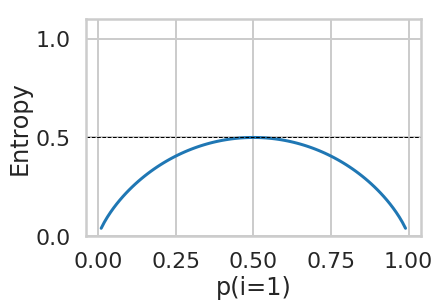

In [7]:
def entropy(p):
    a = - p*np.log2(p) - (1 - p)*np.log2((1 - p))
    return a/2

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.plot(x, ent)
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
plt.ylabel('Entropy')
plt.show()

#### Gini Impurity

$$I_G(t) =  \sum_{i =1}^{C}p(i \mid t) \big(1-p(i \mid t)\big)$$

Gini index says, if we randomly select two items from a population, they must be of the same class and probability for this is 1 if the population is pure.

It works with the categorical target variable “Success” or “Failure”. It performs only binary splits. Higher the value of Gini, higher the homogeneity. The classic CART (Classification and Regression Tree) uses the Gini method to create binary splits.

Exercise: Plot the Gini index over the domain [0,1]

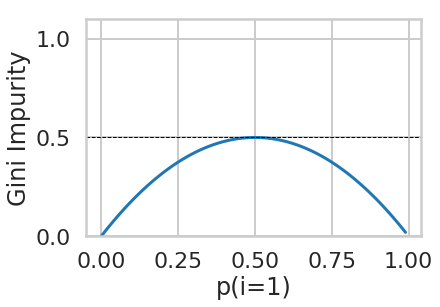

In [9]:
def gini(p):
    return (p)*(1 - (p)) + (1-p)*(1 - (1-p))

x = np.arange(0.0, 1.0, 0.01)
plt.plot(x, gini(x))
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
plt.ylabel('Gini Impurity')
plt.show()

#### Misclassification Error

$$I_M(t) =  1 - max\{{p_i}\}$$

The misclassification error is merely (as we know) the number of incorrectly predicted points.

Exercise: Plot the Misclassification index over the domain [0,1]

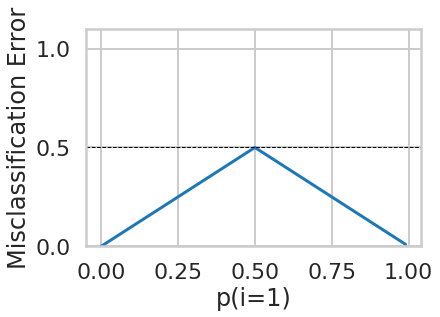

In [8]:
def error(p):
    return 1 - np.max([p, 1-p])

x = np.arange(0.0, 1.0, 0.01)
err = [error(i) for i in x]
plt.plot(x, err)
plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
plt.ylabel('Misclassification Error')
plt.show()

### Comparing the Indices

/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


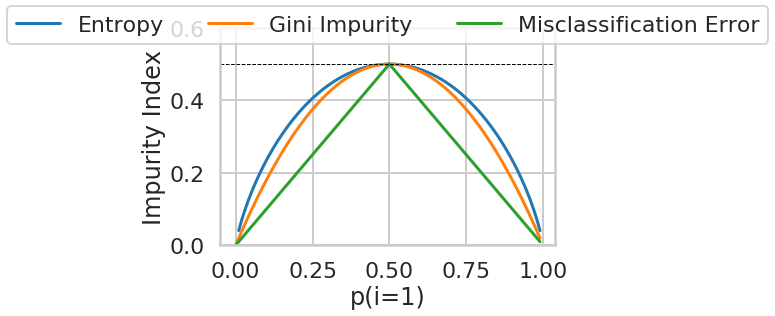

In [11]:
fig = plt.figure()
ax = plt.subplot(111)

for i, lab in zip([ent, gini(x), err], 
                  ['Entropy', 'Gini Impurity', 'Misclassification Error']):
    line, = ax.plot(x, i, label=lab)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0,.6])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.tight_layout()
plt.show()

### Creating a Decision Tree on Fake data

Let's start by doing what we did in the first lab, creating some fake data in order to motivate understanding of how DecisionTrees work and how to use them.  This time we'll use the make_blob function from sklearn.datasets.  As a result we'll get 4 nice somewhat separated clusters of labelled data.

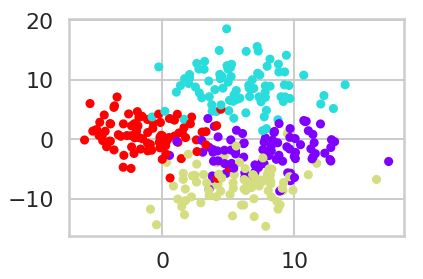

In [13]:
X, y = make_blobs(n_samples=350, centers=4,
                  random_state=3012, cluster_std=3.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

We can run the Decision tree model almost exactly in the same way as the previous sklearn models because of the consistency of the sklearn API.  Let's create a Decision Treee model and fit it on our data.

Exercise: Create a Decision Tree model to fit our fake data

In [14]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Let's use some code to visualize how the decision tree defines boundaries on our region.

In [20]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Exercise: Visualise the regions of our Decision Tree

/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


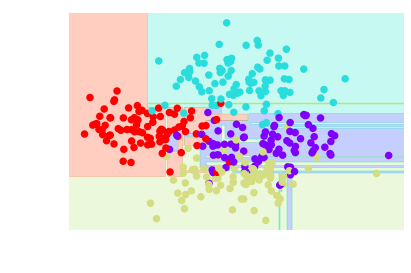

In [21]:
visualize_classifier(dt_model, X, y)

Exercise:  How accurate is our mode?  Determine the proportion of correctly labelled points.

In [23]:
accuracy_score(y, dt_model.predict(X))

1.0

What happens if we arbitrarily restrict tree-depth?

Exercise: Create a decision tree model that fits our fake data with a maximum tree-depth of 3.  Visualize it and show the accuracy

In [23]:
dt_model2 = DecisionTreeClassifier(max_depth=3)
dt_model2.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

/home/igodo/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


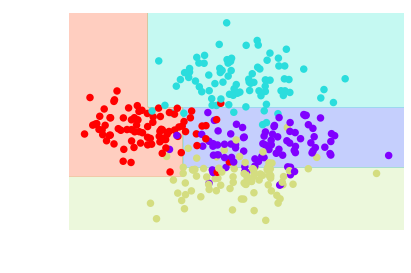

In [25]:
visualize_classifier(dt_model2, X, y)

In [24]:
accuracy_score(y, dt_model2.predict(X))

0.8657142857142858

### Regression Tree Example

What happens if we're trying to solve a regression problem with a decision tree? We could use a simple Decision Tree regressor to fit such a model. We can also use it to illustrate overfitting in Decision Trees

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

In [29]:
x = np.arange(0, 2*np.pi, 0.1)
y = np.sin(x) + 0.1*np.random.normal(size=x.shape[0])

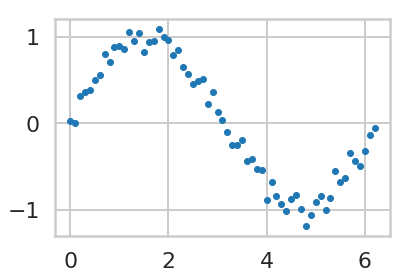

In [30]:
with sns.plotting_context('poster'):
    plt.plot(x,y, '.');

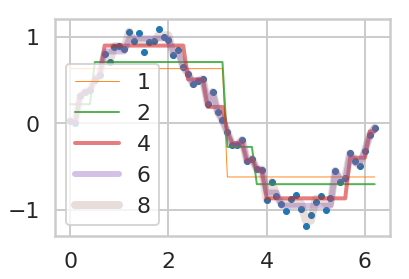

In [31]:
with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    xx = x.reshape(-1,1)
    for i in [1,2,4,6,8]:
        dtsin = DecisionTreeRegressor(max_depth=i)
        dtsin.fit(xx, y)
        plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
    plt.legend();

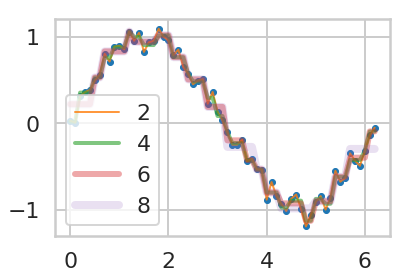

In [32]:
with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    xx = x.reshape(-1,1)
    for i in [2,4,6,8]:
        dtsin = DecisionTreeRegressor(min_samples_split=i)
        dtsin.fit(xx, y)
        plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
    plt.legend();

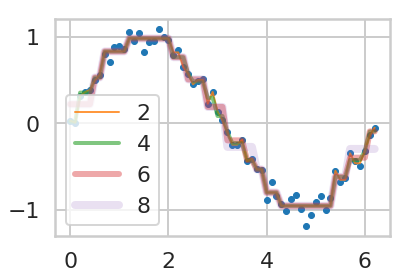

In [33]:
with sns.plotting_context('poster'):
    plt.plot(x,y,'.')
    xx = x.reshape(-1,1)
    for i in [2,4,6,8]:
        dtsin = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
        dtsin.fit(xx, y)
        plt.plot(x, dtsin.predict(xx), label=str(i), alpha=1-i/10, lw=i)
    plt.legend();

### Decision Trees on "Real" Data

#### Dataset

First, the data. This one is built into sklearn, its a dataset about irises.

In [46]:
from sklearn.datasets import load_iris

In [52]:
iris = load_iris()

In [66]:
iris.data[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [67]:
iris.target[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    test_size=0.2)
names = iris.feature_names

In [58]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

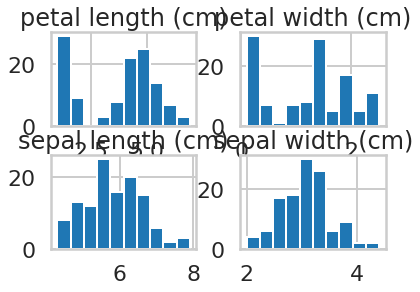

In [62]:
df = pd.DataFrame(data=X_train, columns=names)
df['Species'] = y_train
df.hist(column=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']);

In [60]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.7,1.5,0.4,0
1,6.3,2.3,4.4,1.3,1
2,5.7,2.9,4.2,1.3,1
3,6.9,3.2,5.7,2.3,2
4,7.7,2.6,6.9,2.3,2


In [61]:
df.shape

(120, 5)

/home/igodo/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/igodo/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


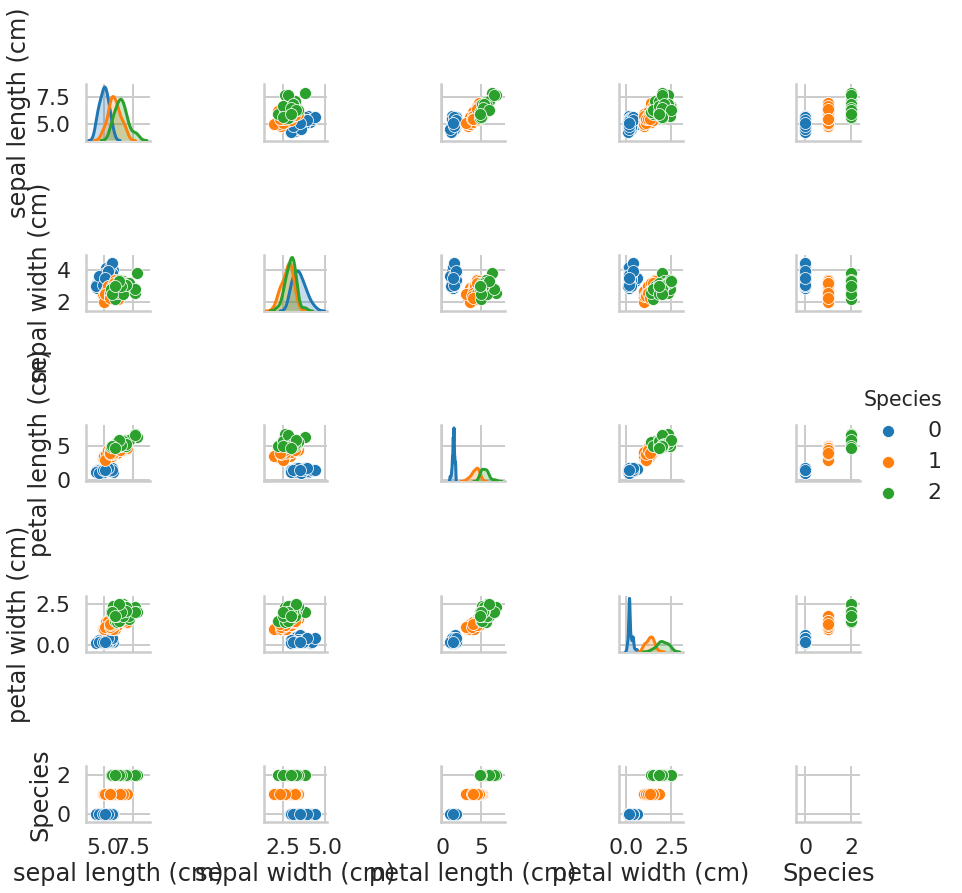

In [63]:
sns.pairplot(df, hue='Species')

Exercise: Create a decision tree model that fits the iris training data.  What is its accuracy on training and test data?

In [64]:
dt_iris_model = DecisionTreeClassifier()
dt_iris_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

How  accurate is the model on the training set?

In [45]:
y_train

array([3.607, 3.333, 2.692, ..., 1.408, 3.5  , 1.852])

In [65]:
accuracy_score(y_train, dt_iris_model.predict(X_train))

1.0

In [68]:
accuracy_score(y_test, dt_iris_model.predict(X_test))

0.9666666666666667